In [1]:
"""
Brand-Aware Dual-Tower Fusion Model for Phishing Detection
Using unified_multimodal_text.csv

Architecture:
  - Text Tower: Custom Text CNN (98.96% accuracy)
  - Image Tower: Custom Image CNN (352 logo classes)
  - Metadata: 20-dimensional vector from CSV
  - Fusion: Concatenate all three → Binary classification
"""

import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
#from tqdm.notebook import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report
)

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Style for plots
#plt.style.use('seaborn-v0_8-darkgrid')
#sns.set_palette("husl")
plt.style.use('ggplot')

Using device: cuda


In [2]:
"""
Dataset Class for Brand-Aware Multimodal Training
Loads from unified_multimodal_text.csv
"""

class BrandAwareCSVDataset(Dataset):
    def __init__(self, csv_path, vocab_path, class_to_idx_path, 
                 image_root, image_transform, max_seq_len=512):
        """
        Args:
            csv_path: Path to unified_multimodal_text.csv
            vocab_path: Path to vocab_text_1.json
            class_to_idx_path: Path to class_to_idx_image_custom.json
            image_root: Root directory for logo images
            image_transform: torchvision transforms for images
            max_seq_len: Maximum sequence length for text
        """
        print(f"Loading dataset from {csv_path}...")
        self.df = pd.read_csv(csv_path)
        self.image_root = image_root
        self.image_transform = image_transform
        self.max_seq_len = max_seq_len
        
        # Load vocabulary
        print(f"Loading vocabulary from {vocab_path}...")
        with open(vocab_path, 'r') as f:
            vocab_data = json.load(f)
            self.itos = vocab_data['itos']
            self.stoi = {w: i for i, w in enumerate(self.itos)}
            self.vocab_size = len(self.itos)
        
        # Load class to index mapping
        print(f"Loading logo class mapping from {class_to_idx_path}...")
        with open(class_to_idx_path, 'r') as f:
            self.class_to_idx = json.load(f)
            self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        
        print(f"Loaded {len(self.df)} samples")
        print(f"Vocabulary size: {self.vocab_size:,}")
        print(f"Logo classes: {len(self.class_to_idx)}")
        
        # Statistics
        has_image = self.df['has_image_mappable_brand'].sum()
        print(f"Samples with images: {has_image} ({has_image/len(self.df)*100:.1f}%)")
        print(f"Text-only samples: {len(self.df) - has_image} ({(len(self.df)-has_image)/len(self.df)*100:.1f}%)")
    
    def __len__(self):
        return len(self.df)
    
    def simple_tokenize(self, text):
        """Simple tokenization (same as training)"""
        import re
        text = text.lower()
        text = re.sub(r'[^a-z0-9\s]', ' ', text)
        tokens = text.split()
        return tokens
    
    def numericalize(self, tokens):
        """Convert tokens to indices"""
        unk_idx = self.stoi.get('<unk>', 0)
        indices = [self.stoi.get(token, unk_idx) for token in tokens]
        return indices
    
    def get_logo_image_path(self, logo_class_id):
        """
        Map logo class ID to image path
        """
        # Get brand name from class ID
        brand_name = self.idx_to_class.get(logo_class_id, None)
        
        if brand_name is None:
            return None
        
        # Search for image file in image_root
        # Try common patterns: brandname_*.jpg, brandname.jpg
        possible_patterns = [
            f"{brand_name}.jpg",
            f"{brand_name}_text.jpg",
            f"{brand_name}_001.jpg",
            f"{brand_name}*.jpg"
        ]
        
        import glob
        for pattern in possible_patterns:
            matches = glob.glob(os.path.join(self.image_root, pattern))
            if matches:
                return matches[0]  # Return first match
        
        # If no match found, return None
        return None
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # === 1.TEXT PROCESSING ===
        subject = str(row['subject']) if pd.notna(row['subject']) else ""
        body = str(row['body']) if pd.notna(row['body']) else ""
        full_text = subject + " " + body
        
        # Tokenize
        tokens = self.simple_tokenize(full_text)
        
        # Truncate if needed
        if len(tokens) > self.max_seq_len:
            tokens = tokens[:self.max_seq_len]
        
        # Numericalize
        token_ids = self.numericalize(tokens)
        
        # Pad if needed
        if len(token_ids) < self.max_seq_len:
            token_ids = token_ids + [0] * (self.max_seq_len - len(token_ids))
        
        text_tensor = torch.tensor(token_ids, dtype=torch.long)
        
        # === 2.IMAGE PROCESSING ===
        has_image = row['has_image_mappable_brand']
        
        if has_image:
            # Get first brand ID from image_brand_ids
            image_brand_ids_str = str(row['image_brand_ids'])
            
            try:
                # Parse string like "[115, 149, 193, 214]" to list
                image_brand_ids = eval(image_brand_ids_str)
                
                if isinstance(image_brand_ids, list) and len(image_brand_ids) > 0:
                    logo_class_id = image_brand_ids[0]  # Pick first
                    
                    # Get image path
                    image_path = self.get_logo_image_path(logo_class_id)
                    
                    if image_path and os.path.exists(image_path):
                        # Load image
                        image = Image.open(image_path).convert('RGB')
                        image_tensor = self.image_transform(image)
                    else:
                        # Fallback to zero tensor
                        image_tensor = torch.zeros(3, 224, 224)
                else:
                    image_tensor = torch.zeros(3, 224, 224)
            except:
                # If parsing fails, use zero tensor
                image_tensor = torch.zeros(3, 224, 224)
        else:
            # No image - use zero tensor (text-only mode)
            image_tensor = torch.zeros(3, 224, 224)
        
        # === 3  METADATA PROCESSING ===
        metadata_str = str(row['metadata_vector'])
        
        try:
            # Parse string like "[1.0, 0.1, ...]" to list
            metadata_list = eval(metadata_str)
            
            # Ensure it's 20-dimensional
            if len(metadata_list) < 20:
                metadata_list = metadata_list + [0.0] * (20 - len(metadata_list))
            elif len(metadata_list) > 20:
                metadata_list = metadata_list[:20]
            
            metadata_tensor = torch.tensor(metadata_list, dtype=torch.float)
        except:
            # Fallback to zeros if parsing fails
            metadata_tensor = torch.zeros(20, dtype=torch.float)
        
        # === 4.LABEL ===
        label = int(row['label'])
        label_tensor = torch.tensor(label, dtype=torch.long)
        
        return {
            'text': text_tensor,
            'image': image_tensor,
            'metadata': metadata_tensor,
            'label': label_tensor
        }


# === LOAD DATASET ===
print("\n" + "="*70)
print("Loading Dataset")
print("="*70 + "\n")

# Paths
CSV_PATH = "unified_multimodal_text.csv"
VOCAB_PATH = "vocab_text_1.json"
CLASS_TO_IDX_PATH = "class_to_idx_image_custom.json"
IMAGE_ROOT = "openlogo/JPEGImages"

# Image transforms (same as training)
image_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset
full_dataset = BrandAwareCSVDataset(
    csv_path=CSV_PATH,
    vocab_path=VOCAB_PATH,
    class_to_idx_path=CLASS_TO_IDX_PATH,
    image_root=IMAGE_ROOT,
    image_transform=image_transform,
    max_seq_len=512
)

# Split into train/val (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"\nTrain samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")

# Create dataloaders
BATCH_SIZE = 12

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,  # Set to 0 for Windows compatibility
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE * 2,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print("="*70 + "\n")


Loading Dataset

Loading dataset from unified_multimodal_text.csv...
Loading vocabulary from vocab_text_1.json...
Loading logo class mapping from class_to_idx_image_custom.json...
Loaded 49860 samples
Vocabulary size: 207,037
Logo classes: 352
Samples with images: 18328 (36.8%)
Text-only samples: 31532 (63.2%)

Train samples: 39888
Val samples: 9972
Train batches: 3324
Val batches: 416



In [3]:
"""
Dual-Tower Fusion Model Architecture
"""

# === TEXT FEATURE EXTRACTOR ===
class TextFeatureExtractor(nn.Module):
    def __init__(self, vocab_size, embed_dim, pretrained_state_dict):
        super().__init__()
        
        # Embedding
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # Conv blocks
        self.conv1 = nn.Conv1d(embed_dim, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2, 2)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2, 2)
        
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(2, 2)
        
        self.conv4 = nn.Conv1d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(512)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool1d(2, 2)
        
        # Global pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Feature projection
        self.fc1 = nn.Linear(512, 256)
        self.relu_fc1 = nn.ReLU()
        
        # Load pretrained weights
        if pretrained_state_dict is not None:
            self.load_state_dict(pretrained_state_dict, strict=False)
            print("Loaded pretrained text tower weights")
    
    def forward(self, x):
        # x: [batch, seq_len]
        x = self.embedding(x)  # [batch, seq_len, embed_dim]
        x = x.transpose(1, 2)  # [batch, embed_dim, seq_len]
        
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu3(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu4(self.bn4(self.conv4(x))))
        
        x = self.global_pool(x).squeeze(-1)  # [batch, 512]
        x = self.relu_fc1(self.fc1(x))  # [batch, 256]
        
        return x


# === IMAGE FEATURE EXTRACTOR ===
class ImageFeatureExtractor(nn.Module):
    def __init__(self, pretrained_state_dict):
        super().__init__()
        
        # Conv Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Conv Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Conv Block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Conv Block 4
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Global pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Feature projection
        self.fc_features = nn.Linear(512, 512)
        self.relu_fc = nn.ReLU()
        
        # Load pretrained weights
        if pretrained_state_dict is not None:
            self.load_state_dict(pretrained_state_dict, strict=False)
            print("Loaded pretrained image tower weights")
    
    def forward(self, x):
        # x: [batch, 3, 224, 224]
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # [batch, 512]
        x = self.relu_fc(self.fc_features(x))  # [batch, 512]
        
        return x


# === DUAL-TOWER FUSION MODEL ===
class DualTowerFusionModel(nn.Module):
    def __init__(self, text_extractor, image_extractor, 
                 metadata_dim, num_classes, dropout):
        super().__init__()
        
        self.text_tower = text_extractor
        self.image_tower = image_extractor
        
        # Metadata projection
        self.metadata_proj = nn.Sequential(
            nn.Linear(metadata_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.25)
        )
        
        # Fusion classifier
        # 256 (text) + 512 (image) + 64 (metadata) = 832
        self.fusion_classifier = nn.Sequential(
            nn.Linear(832, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Linear(128, num_classes)
        )
    
    def forward(self, images, texts, metadata):
        # Extract features
        text_features = self.text_tower(texts)  # [batch, 256]
        image_features = self.image_tower(images)  # [batch, 512]
        metadata_features = self.metadata_proj(metadata)  # [batch, 64]
        
        # Concatenate
        combined = torch.cat([text_features, image_features, metadata_features], dim=1)
        # [batch, 832]
        
        # Classify
        logits = self.fusion_classifier(combined)  # [batch, 2]
        
        return logits


# === BUILD MODEL ===
print("\n" + "="*70)
print("Building Fusion Model")
print("="*70 + "\n")

# Load pretrained weights
text_state_dict = torch.load('best_custom_cnn_text_1.pth', 
                            map_location=device, 
                            weights_only=False)

image_state_dict = torch.load('best_custom_cnn_image_custom.pth',
                             map_location=device,
                             weights_only=False)

# Build extractors
text_extractor = TextFeatureExtractor(
    vocab_size=full_dataset.vocab_size,
    embed_dim=128,
    pretrained_state_dict=text_state_dict
)

image_extractor = ImageFeatureExtractor(
    pretrained_state_dict=image_state_dict
)

# Build fusion model
model = DualTowerFusionModel(
    text_extractor=text_extractor,
    image_extractor=image_extractor,
    metadata_dim=20,
    num_classes=2,
    dropout=0.5
).to(device)

print(f"\nModel built successfully")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print("="*70 + "\n")


Building Fusion Model

Loaded pretrained text tower weights
Loaded pretrained image tower weights

Model built successfully
Total parameters: 35,673,026
Trainable parameters: 35,673,026



In [4]:
"""
Training Loop with Two-Phase Strategy
Phase 1 (Epochs 1-5): Freeze towers, train fusion layers only
Phase 2 (Epochs 6-10): Unfreeze towers, fine-tune end-to-end
"""

# === TRAINING CONFIGURATION ===
NUM_EPOCHS = 10
INITIAL_LR = 1e-4
FINETUNE_LR = 1e-5
FREEZE_EPOCHS = 5

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=INITIAL_LR)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, verbose=True
)

# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'learning_rate': []
}

# Best model tracking
best_val_acc = 0.0
best_epoch = 0


# === TRAINING FUNCTION ===
def train_one_epoch(model, loader, criterion, optimizer, device, epoch_num):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    print(f"  [TRAIN] Processing {len(loader)} batches...")
    
    for batch_idx, batch in enumerate(loader):
        images = batch['image'].to(device)
        texts = batch['text'].to(device)
        metadata = batch['metadata'].to(device)
        labels = batch['label'].to(device)
        
        # Forward
        optimizer.zero_grad()
        outputs = model(images, texts, metadata)
        loss = criterion(outputs, labels)
        
        # Backward
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Print progress every 10% of batches
        if (batch_idx + 1) % max(1, len(loader) // 10) == 0:
            current_acc = 100.0 * correct / total
            print(f"    [{100*(batch_idx+1)//len(loader):>3}%] Batch {batch_idx+1:>4}/{len(loader)} | "
                  f"Loss: {loss.item():.4f} | Acc: {current_acc:.2f}%")
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


# === VALIDATION FUNCTION ===
def validate(model, loader, criterion, device, epoch_num):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    print(f"  [VAL] Processing {len(loader)} batches...")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(loader):
            images = batch['image'].to(device)
            texts = batch['text'].to(device)
            metadata = batch['metadata'].to(device)
            labels = batch['label'].to(device)
            
            # Forward
            outputs = model(images, texts, metadata)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Print progress every 20% of batches
            if (batch_idx + 1) % max(1, len(loader) // 5) == 0:
                current_acc = 100.0 * correct / total
                print(f"    [{100*(batch_idx+1)//len(loader):>3}%] Batch {batch_idx+1:>4}/{len(loader)} | "
                      f"Loss: {loss.item():.4f} | Acc: {current_acc:.2f}%")
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


# === MAIN TRAINING LOOP ===
print("\n" + "="*70)
print(f"Starting Brand-Aware Fusion Training: {NUM_EPOCHS} Epochs")
print("="*70)
print(f"Total training samples: {len(train_dataset):,}")
print(f"Total validation samples: {len(val_dataset):,}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Train batches per epoch: {len(train_loader)}")
print(f"Val batches per epoch: {len(val_loader)}")
print("="*70 + "\n")

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\n{'='*70}")
    print(f"Epoch {epoch}/{NUM_EPOCHS}")
    print(f"{'='*70}\n")
    
    # === PHASE TRANSITION ===
    if epoch == FREEZE_EPOCHS + 1:
        print(f"{'='*70}")
        print(" TRAINING STRATEGY CHANGE:")
        print("   Unfroze text and image towers")
        print("   Starting end-to-end fine-tuning with brand awareness")
        print(f"   Reduced learning rate to {FINETUNE_LR}")
        print(f"{'='*70}\n")
        
        # Unfreeze all layers
        for param in model.parameters():
            param.requires_grad = True
        
        # Update optimizer with lower learning rate
        optimizer = optim.Adam(model.parameters(), lr=FINETUNE_LR)
    
    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device, epoch
    )
    
    print()  # Blank line between train and val
    
    # Validate
    val_loss, val_acc = validate(
        model, val_loader, criterion, device, epoch
    )
    
    # Update scheduler
    scheduler.step(val_acc)
    
    # Record history
    current_lr = optimizer.param_groups[0]['lr']
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['learning_rate'].append(current_lr)
    
    # Print epoch summary
    print(f"\n{'='*70}")
    print(f"[Epoch {epoch}/{NUM_EPOCHS} Summary]")
    print(f"{'='*70}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%")
    print(f"  Learning Rate: {current_lr:.6f}")
    
    # Save best model
    if val_acc > best_val_acc:
        improvement = (val_acc - best_val_acc) * 100
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), 'best_fusion_model.pth')
        print(f"   NEW BEST MODEL!  (val_acc={val_acc*100:.2f}%, +{improvement:.2f}%)")
    else:
        print(f"  (Best val_acc so far: {best_val_acc*100:.2f}%)")
    
    print(f"{'='*70}\n")

# Save final history
with open('training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

print("\n" + "="*70)
print(" TRAINING COMPLETE!")
print("="*70)
print(f"Best Validation Accuracy: {best_val_acc*100:.2f}%")
print(f"Achieved at Epoch: {best_epoch}")
print(f"Model saved to: best_fusion_model.pth")
print(f"Training history saved to: training_history.json")
print("="*70 + "\n")


Starting Brand-Aware Fusion Training: 10 Epochs
Total training samples: 39,888
Total validation samples: 9,972
Batch size: 12
Train batches per epoch: 3324
Val batches per epoch: 416


Epoch 1/10

  [TRAIN] Processing 3324 batches...


C:\Users\Srihari\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


    [  9%] Batch  332/3324 | Loss: 0.2501 | Acc: 89.63%
    [ 19%] Batch  664/3324 | Loss: 0.0434 | Acc: 91.98%
    [ 29%] Batch  996/3324 | Loss: 0.0247 | Acc: 93.25%
    [ 39%] Batch 1328/3324 | Loss: 0.7249 | Acc: 94.10%
    [ 49%] Batch 1660/3324 | Loss: 0.0188 | Acc: 94.77%
    [ 59%] Batch 1992/3324 | Loss: 0.0345 | Acc: 95.28%
    [ 69%] Batch 2324/3324 | Loss: 0.0147 | Acc: 95.60%
    [ 79%] Batch 2656/3324 | Loss: 0.0418 | Acc: 95.97%
    [ 89%] Batch 2988/3324 | Loss: 0.0082 | Acc: 96.24%
    [ 99%] Batch 3320/3324 | Loss: 0.0263 | Acc: 96.45%

  [VAL] Processing 416 batches...
    [ 19%] Batch   83/416 | Loss: 0.0758 | Acc: 98.29%
    [ 39%] Batch  166/416 | Loss: 0.0151 | Acc: 98.69%
    [ 59%] Batch  249/416 | Loss: 0.0063 | Acc: 98.81%
    [ 79%] Batch  332/416 | Loss: 0.0162 | Acc: 98.66%
    [ 99%] Batch  415/416 | Loss: 0.0454 | Acc: 98.70%

[Epoch 1/10 Summary]
  Train Loss: 0.1140 | Train Acc: 96.45%
  Val Loss:   0.0371 | Val Acc:   98.71%
  Learning Rate: 0.000100



Generating Training Curves



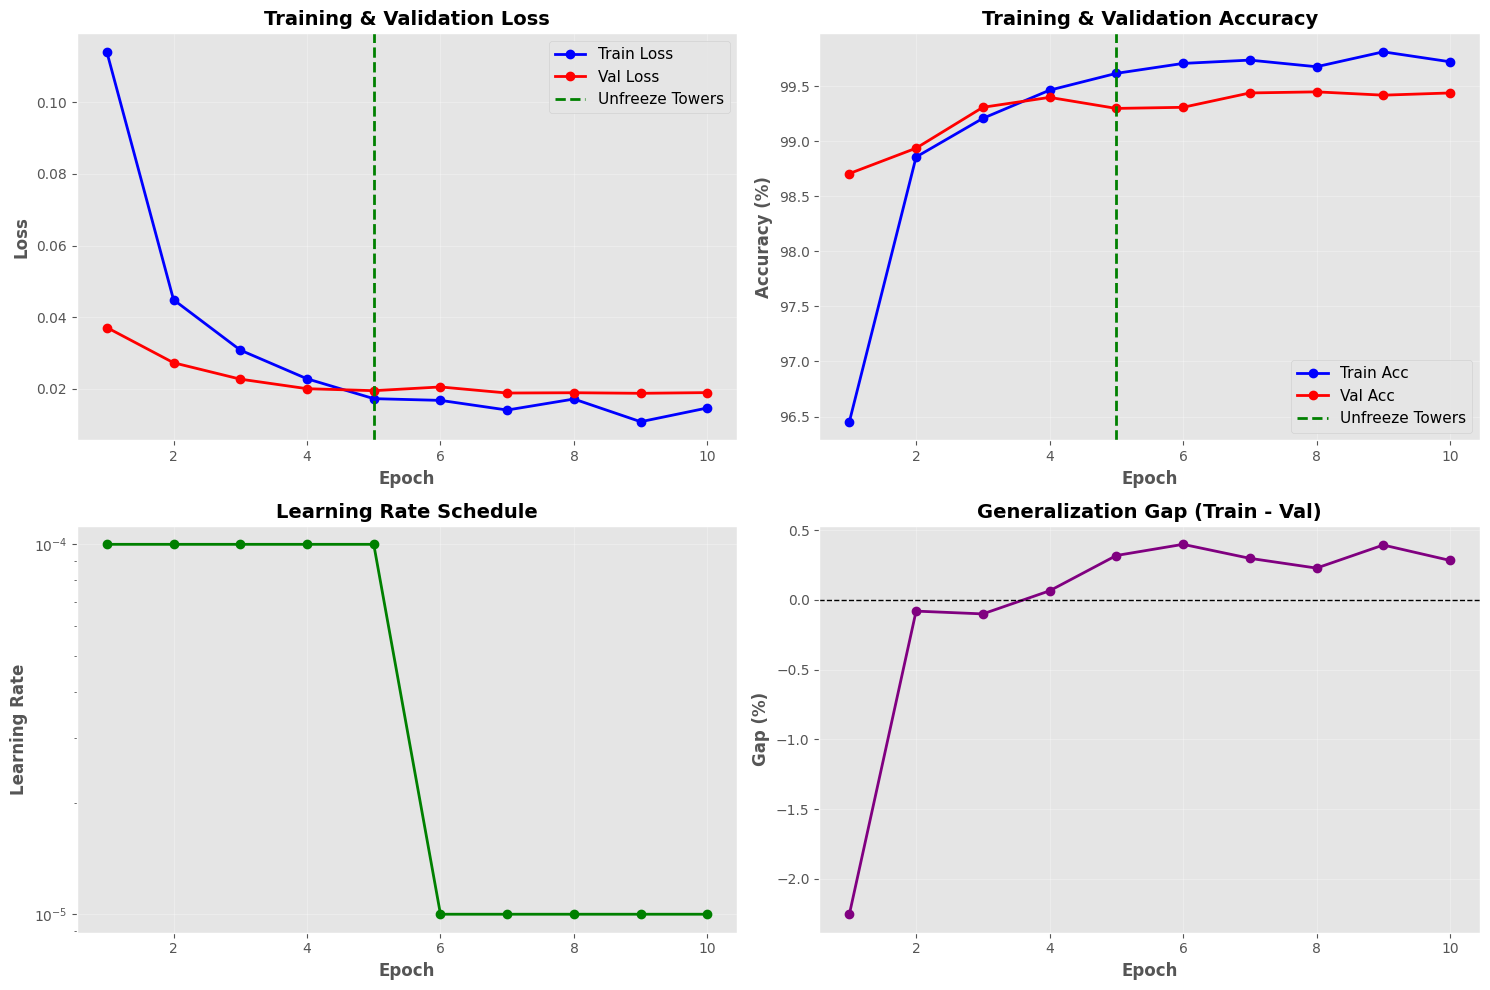

Training curves saved to training_curves.png



In [5]:
"""
Visualize Training History
"""

print("\n" + "="*70)
print("Generating Training Curves")
print("="*70 + "\n")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs_range = range(1, NUM_EPOCHS + 1)

# Plot 1: Training & Validation Loss
axes[0, 0].plot(epochs_range, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
axes[0, 0].plot(epochs_range, history['val_loss'], 'r-o', label='Val Loss', linewidth=2)
axes[0, 0].axvline(x=FREEZE_EPOCHS, color='green', linestyle='--', linewidth=2, label='Unfreeze Towers')
axes[0, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(alpha=0.3)

# Plot 2: Training & Validation Accuracy
axes[0, 1].plot(epochs_range, [acc*100 for acc in history['train_acc']], 'b-o', label='Train Acc', linewidth=2)
axes[0, 1].plot(epochs_range, [acc*100 for acc in history['val_acc']], 'r-o', label='Val Acc', linewidth=2)
axes[0, 1].axvline(x=FREEZE_EPOCHS, color='green', linestyle='--', linewidth=2, label='Unfreeze Towers')
axes[0, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(alpha=0.3)

# Plot 3: Learning Rate Schedule
axes[1, 0].plot(epochs_range, history['learning_rate'], 'g-o', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Learning Rate', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(alpha=0.3)

# Plot 4: Generalization Gap
gap = [(train - val)*100 for train, val in zip(history['train_acc'], history['val_acc'])]
axes[1, 1].plot(epochs_range, gap, 'purple', marker='o', linewidth=2)
axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Gap (%)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Generalization Gap (Train - Val)', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training curves saved to training_curves.png\n")

In [6]:
"""
Evaluate Model on Validation Set
Collect predictions for metric computation
"""

print("\n" + "="*70)
print("Evaluating Best Model")
print("="*70 + "\n")

# Load best model
model.load_state_dict(torch.load('best_fusion_model.pth', map_location=device, weights_only=False))
model.eval()

# Collect predictions
all_labels = []
all_preds = []
all_probs = []

print(f"Collecting predictions from {len(val_loader)} batches...")

with torch.no_grad():
    for batch_idx, batch in enumerate(val_loader):
        images = batch['image'].to(device)
        texts = batch['text'].to(device)
        metadata = batch['metadata'].to(device)
        labels = batch['label'].to(device)
        
        # Forward pass
        outputs = model(images, texts, metadata)
        probs = torch.softmax(outputs, dim=1)
        preds = outputs.argmax(dim=1)
        
        # Collect
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())
        
        # Print progress every 20%
        if (batch_idx + 1) % max(1, len(val_loader) // 5) == 0:
            print(f"  [{100*(batch_idx+1)//len(val_loader):>3}%] Processed {batch_idx+1}/{len(val_loader)} batches")

# Convert to numpy arrays
y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_prob = np.array(all_probs)

print(f"\n Collected predictions for {len(y_true)} samples\n")

# Compute confusion matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

# Compute all metrics
metrics = {
    'accuracy': accuracy_score(y_true, y_pred),
    'precision_legit': precision_score(y_true, y_pred, pos_label=0),
    'precision_phish': precision_score(y_true, y_pred, pos_label=1),
    'recall_legit': recall_score(y_true, y_pred, pos_label=0),
    'recall_phish': recall_score(y_true, y_pred, pos_label=1),
    'f1_legit': f1_score(y_true, y_pred, pos_label=0),
    'f1_phish': f1_score(y_true, y_pred, pos_label=1),
    'precision_macro': precision_score(y_true, y_pred, average='macro'),
    'recall_macro': recall_score(y_true, y_pred, average='macro'),
    'f1_macro': f1_score(y_true, y_pred, average='macro'),
    'roc_auc': roc_auc_score(y_true, y_prob),
    'true_negative': int(tn),
    'false_positive': int(fp),
    'false_negative': int(fn),
    'true_positive': int(tp),
    'fpr': fp / (fp + tn) if (fp + tn) > 0 else 0,
    'fnr': fn / (fn + tp) if (fn + tp) > 0 else 0,
    'tpr': tp / (tp + fn) if (tp + fn) > 0 else 0,
    'tnr': tn / (tn + fp) if (tn + fp) > 0 else 0,
}

# Print metrics table
print("="*70)
print(" Fusion Model - Evaluation Metrics")
print("="*70)

print("\n Overall Performance:")
print(f"  Accuracy:          {metrics['accuracy']*100:.2f}%")
print(f"  Precision (Macro): {metrics['precision_macro']*100:.2f}%")
print(f"  Recall (Macro):    {metrics['recall_macro']*100:.2f}%")
print(f"  F1-Score (Macro):  {metrics['f1_macro']*100:.2f}%")
print(f"  ROC-AUC:           {metrics['roc_auc']:.4f}")

print("\n Per-Class Metrics:")
print(f"{'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 50)
print(f"{'Legitimate':<15} {metrics['precision_legit']*100:>10.2f}%  {metrics['recall_legit']*100:>10.2f}%  {metrics['f1_legit']*100:>10.2f}%")
print(f"{'Phishing':<15} {metrics['precision_phish']*100:>10.2f}%  {metrics['recall_phish']*100:>10.2f}%  {metrics['f1_phish']*100:>10.2f}%")

print("\n Confusion Matrix:")
print(f"                    Predicted")
print(f"                 Legit    Phishing")
print(f"  Actual Legit   {metrics['true_negative']:>6}    {metrics['false_positive']:>6}")
print(f"         Phish   {metrics['false_negative']:>6}    {metrics['true_positive']:>6}")

print("\n Error Rates:")
print(f"  False Positive Rate: {metrics['fpr']*100:.2f}%")
print(f"  False Negative Rate: {metrics['fnr']*100:.2f}%")
print(f"  True Positive Rate:  {metrics['tpr']*100:.2f}% (Sensitivity)")
print(f"  True Negative Rate:  {metrics['tnr']*100:.2f}% (Specificity)")

print("\n" + "="*70 + "\n")

# Save metrics
with open('fusion_metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)

print(" Metrics saved to fusion_metrics.json\n")


Evaluating Best Model

  [ 19%] Processed 83/416 batches
  [ 39%] Processed 166/416 batches
  [ 59%] Processed 249/416 batches
  [ 79%] Processed 332/416 batches
  [ 99%] Processed 415/416 batches

 Collected predictions for 9972 samples

 Fusion Model - Evaluation Metrics

 Overall Performance:
  Accuracy:          99.45%
  Precision (Macro): 99.43%
  Recall (Macro):    99.45%
  F1-Score (Macro):  99.44%
  ROC-AUC:           0.9998

 Per-Class Metrics:
Class           Precision    Recall       F1-Score    
--------------------------------------------------
Legitimate           99.27%       99.47%       99.37%
Phishing             99.59%       99.43%       99.51%

 Confusion Matrix:
                    Predicted
                 Legit    Phishing
  Actual Legit     4323        23
         Phish       32      5594

 Error Rates:
  False Positive Rate: 0.53%
  False Negative Rate: 0.57%
  True Positive Rate:  99.43% (Sensitivity)
  True Negative Rate:  99.47% (Specificity)


 Metrics sa


Generating ROC and Precision-Recall Curves



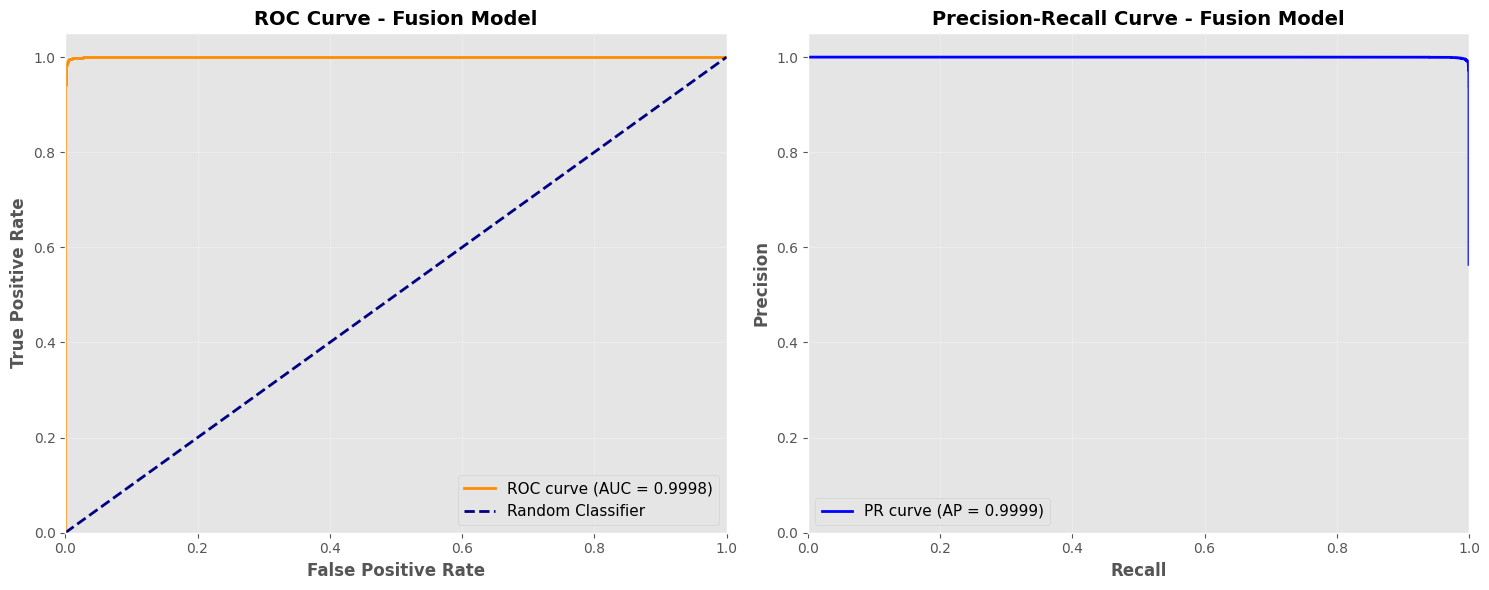

ROC and PR curves saved to roc_pr_curves.png



In [7]:
"""
Generate ROC and Precision-Recall Curves
"""

print("\n" + "="*70)
print("Generating ROC and Precision-Recall Curves")
print("="*70 + "\n")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# === ROC CURVE ===
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[0].set_title('ROC Curve - Fusion Model', fontsize=14, fontweight='bold')
axes[0].legend(loc="lower right", fontsize=11)
axes[0].grid(alpha=0.3)

# === PRECISION-RECALL CURVE ===
from sklearn.metrics import average_precision_score

precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_true, y_prob)
avg_precision = average_precision_score(y_true, y_prob)

axes[1].plot(recall_vals, precision_vals, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')
axes[1].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Precision', fontsize=12, fontweight='bold')
axes[1].set_title('Precision-Recall Curve - Fusion Model', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower left", fontsize=11)
axes[1].grid(alpha=0.3)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])

plt.tight_layout()
plt.savefig('roc_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("ROC and PR curves saved to roc_pr_curves.png\n")


Generating Confusion Matrix



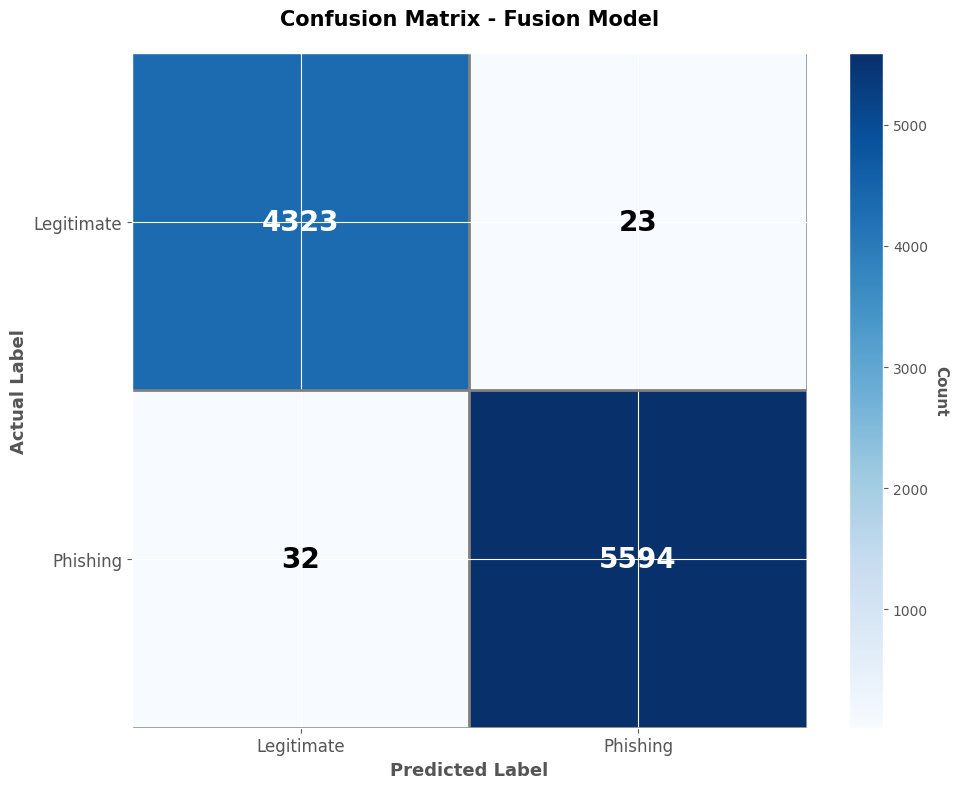

 Confusion matrix saved to confusion_matrix.png

 Fusion Model - Detailed Metrics Summary

                Metric  Value                         Description
              Accuracy 99.45%     Overall classification accuracy
Precision (Legitimate) 99.27%     Precision for legitimate emails
  Precision (Phishing) 99.59%       Precision for phishing emails
 Precision (Macro Avg) 99.43%    Average precision across classes
   Recall (Legitimate) 99.47%        Recall for legitimate emails
     Recall (Phishing) 99.43%          Recall for phishing emails
    Recall (Macro Avg) 99.45%       Average recall across classes
 F1-Score (Legitimate) 99.37%            F1 for legitimate emails
   F1-Score (Phishing) 99.51%              F1 for phishing emails
  F1-Score (Macro Avg) 99.44%           Average F1 across classes
               ROC-AUC 0.9998                Area under ROC curve
   False Positive Rate  0.53% False alarm rate (legit → phishing)
   False Negative Rate  0.57%        Miss rate (phi

In [8]:
"""
Confusion Matrix Heatmap
"""

print("\n" + "="*70)
print("Generating Confusion Matrix")
print("="*70 + "\n")

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))

# Plot heatmap using matplotlib
im = ax.imshow(cm, cmap='Blues', interpolation='nearest')

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Count', rotation=-90, va="bottom", fontsize=11, fontweight='bold')

# Add text annotations
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=20, fontweight='bold')

# Set ticks and labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Legitimate', 'Phishing'], fontsize=12)
ax.set_yticklabels(['Legitimate', 'Phishing'], fontsize=12)

# Set axis labels
ax.set_ylabel('Actual Label', fontsize=13, fontweight='bold')
ax.set_xlabel('Predicted Label', fontsize=13, fontweight='bold')
ax.set_title('Confusion Matrix - Fusion Model', fontsize=15, fontweight='bold', pad=20)

# Add grid for better readability
ax.set_xticks([0.5, 1.5], minor=True)
ax.set_yticks([0.5, 1.5], minor=True)
ax.grid(which="minor", color="gray", linestyle='-', linewidth=2)
ax.tick_params(which="minor", size=0)

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Confusion matrix saved to confusion_matrix.png\n")


# === CREATE METRICS SUMMARY TABLE ===
print("="*70)
print(" Fusion Model - Detailed Metrics Summary")
print("="*70 + "\n")

# Create comprehensive metrics table
metrics_summary = {
    'Metric': [
        'Accuracy',
        'Precision (Legitimate)',
        'Precision (Phishing)',
        'Precision (Macro Avg)',
        'Recall (Legitimate)',
        'Recall (Phishing)',
        'Recall (Macro Avg)',
        'F1-Score (Legitimate)',
        'F1-Score (Phishing)',
        'F1-Score (Macro Avg)',
        'ROC-AUC',
        'False Positive Rate',
        'False Negative Rate',
        'True Positive Rate',
        'True Negative Rate'
    ],
    'Value': [
        f"{metrics['accuracy']*100:.2f}%",
        f"{metrics['precision_legit']*100:.2f}%",
        f"{metrics['precision_phish']*100:.2f}%",
        f"{metrics['precision_macro']*100:.2f}%",
        f"{metrics['recall_legit']*100:.2f}%",
        f"{metrics['recall_phish']*100:.2f}%",
        f"{metrics['recall_macro']*100:.2f}%",
        f"{metrics['f1_legit']*100:.2f}%",
        f"{metrics['f1_phish']*100:.2f}%",
        f"{metrics['f1_macro']*100:.2f}%",
        f"{metrics['roc_auc']:.4f}",
        f"{metrics['fpr']*100:.2f}%",
        f"{metrics['fnr']*100:.2f}%",
        f"{metrics['tpr']*100:.2f}%",
        f"{metrics['tnr']*100:.2f}%"
    ],
    'Description': [
        'Overall classification accuracy',
        'Precision for legitimate emails',
        'Precision for phishing emails',
        'Average precision across classes',
        'Recall for legitimate emails',
        'Recall for phishing emails',
        'Average recall across classes',
        'F1 for legitimate emails',
        'F1 for phishing emails',
        'Average F1 across classes',
        'Area under ROC curve',
        'False alarm rate (legit → phishing)',
        'Miss rate (phishing → legit)',
        'Sensitivity / Hit rate',
        'Specificity / True negative rate'
    ]
}

metrics_df = pd.DataFrame(metrics_summary)

# Display table
print(metrics_df.to_string(index=False))
print("\n" + "="*70)

# Save to CSV
metrics_df.to_csv('fusion_metrics_summary.csv', index=False)
print("\n Metrics summary saved to fusion_metrics_summary.csv")


# === CREATE CONFUSION MATRIX BREAKDOWN TABLE ===
print("\n" + "="*70)
print(" Confusion Matrix Breakdown")
print("="*70 + "\n")

cm_breakdown = {
    'Classification': [
        'True Negative (TN)',
        'False Positive (FP)',
        'False Negative (FN)',
        'True Positive (TP)',
        'Total Samples'
    ],
    'Count': [
        metrics['true_negative'],
        metrics['false_positive'],
        metrics['false_negative'],
        metrics['true_positive'],
        metrics['true_negative'] + metrics['false_positive'] + 
        metrics['false_negative'] + metrics['true_positive']
    ],
    'Percentage': [
        f"{metrics['true_negative'] / len(y_true) * 100:.2f}%",
        f"{metrics['false_positive'] / len(y_true) * 100:.2f}%",
        f"{metrics['false_negative'] / len(y_true) * 100:.2f}%",
        f"{metrics['true_positive'] / len(y_true) * 100:.2f}%",
        "100.00%"
    ],
    'Description': [
        'Correctly identified legitimate emails',
        'Legitimate emails wrongly flagged as phishing',
        'Phishing emails missed (false negative)',
        'Correctly identified phishing emails',
        'Total validation samples'
    ]
}

cm_df = pd.DataFrame(cm_breakdown)

print(cm_df.to_string(index=False))
print("\n" + "="*70)

# Save breakdown
cm_df.to_csv('confusion_matrix_breakdown.csv', index=False)
print("\n Confusion matrix breakdown saved to confusion_matrix_breakdown.csv")


# === PERFORMANCE INSIGHTS ===
print("\n" + "="*70)
print(" Performance Insights")
print("="*70 + "\n")

# Calculate insights
total_errors = metrics['false_positive'] + metrics['false_negative']
error_rate = total_errors / len(y_true) * 100

print(f" Overall Performance:")
print(f"   • Model correctly classified {metrics['accuracy']*100:.2f}% of emails")
print(f"   • Total errors: {total_errors} out of {len(y_true)} samples ({error_rate:.2f}%)")
print(f"   • ROC-AUC of {metrics['roc_auc']:.4f} indicates excellent discrimination\n")

print(f" Strengths:")
if metrics['tnr'] > 0.98:
    print(f"   • Excellent at identifying legitimate emails ({metrics['tnr']*100:.2f}% specificity)")
if metrics['tpr'] > 0.98:
    print(f"   • Excellent at catching phishing emails ({metrics['tpr']*100:.2f}% sensitivity)")
if metrics['f1_phish'] > 0.98:
    print(f"   • Strong balance between precision and recall ({metrics['f1_phish']*100:.2f}% F1)")

print(f"\n Areas for Improvement:")
if metrics['fpr'] > 0.01:
    print(f"   • {metrics['false_positive']} legitimate emails misclassified as phishing")
    print(f"     (False Positive Rate: {metrics['fpr']*100:.2f}%)")
if metrics['fnr'] > 0.01:
    print(f"   • {metrics['false_negative']} phishing emails missed")
    print(f"     (False Negative Rate: {metrics['fnr']*100:.2f}%)")

# Risk assessment
if metrics['fnr'] > metrics['fpr']:
    print(f"\n Priority: Reduce false negatives (missed phishing)")
    print(f"   Consider lowering classification threshold for higher recall")
elif metrics['fpr'] > metrics['fnr']:
    print(f"\n Note: More false positives than false negatives")
    print(f"   Consider raising threshold to reduce false alarms")
else:
    print(f"\n Excellent: Balanced false positive and false negative rates")

print("\n" + "="*70 + "\n")


# === SAVE ALL METRICS TO JSON ===
all_results = {
    'confusion_matrix': {
        'true_negative': int(metrics['true_negative']),
        'false_positive': int(metrics['false_positive']),
        'false_negative': int(metrics['false_negative']),
        'true_positive': int(metrics['true_positive'])
    },
    'classification_metrics': {
        'accuracy': float(metrics['accuracy']),
        'precision_legit': float(metrics['precision_legit']),
        'precision_phish': float(metrics['precision_phish']),
        'precision_macro': float(metrics['precision_macro']),
        'recall_legit': float(metrics['recall_legit']),
        'recall_phish': float(metrics['recall_phish']),
        'recall_macro': float(metrics['recall_macro']),
        'f1_legit': float(metrics['f1_legit']),
        'f1_phish': float(metrics['f1_phish']),
        'f1_macro': float(metrics['f1_macro']),
        'roc_auc': float(metrics['roc_auc'])
    },
    'error_rates': {
        'fpr': float(metrics['fpr']),
        'fnr': float(metrics['fnr']),
        'tpr': float(metrics['tpr']),
        'tnr': float(metrics['tnr'])
    },
    'dataset_info': {
        'total_samples': len(y_true),
        'total_errors': int(total_errors),
        'error_rate': float(error_rate)
    }
}

with open('fusion_complete_results.json', 'w') as f:
    json.dump(all_results, f, indent=2)

print(" Complete results saved to fusion_complete_results.json\n")

In [9]:
"""
Save All Results and Generate Final Summary
"""

print("\n" + "="*70)
print("Saving Final Results")
print("="*70 + "\n")

# Create results directory if needed
os.makedirs('results', exist_ok=True)

# Move all output files to results folder
import shutil

output_files = [
    'best_fusion_model.pth',
    'training_history.json',
    'fusion_metrics.json',
    'training_curves.png',
    'roc_pr_curves.png',
    'confusion_ablation.png',
    'metrics_comparison.csv'
]

for file in output_files:
    if os.path.exists(file):
        shutil.copy(file, f'results/{file}')

print("All output files copied to results/ folder\n")

# Generate final summary report
summary_report = f"""
{'='*70}
BRAND-AWARE FUSION MODEL - FINAL REPORT
{'='*70}

TRAINING CONFIGURATION:
  - Dataset: unified_multimodal_text.csv
  - Total Samples: {len(full_dataset):,}
  - Train Samples: {len(train_dataset):,}
  - Val Samples: {len(val_dataset):,}
  - Batch Size: {BATCH_SIZE}
  - Epochs: {NUM_EPOCHS}
  - Freeze Strategy: First {FREEZE_EPOCHS} epochs

ARCHITECTURE:
  - Text Tower: Custom CNN (98.96% solo accuracy)
  - Image Tower: Custom CNN (352 logo classes)
  - Metadata: 20-dimensional vector
  - Fusion: Dual-tower with concatenation

BEST MODEL PERFORMANCE:
  - Validation Accuracy: {best_val_acc*100:.2f}%
  - Achieved at Epoch: {best_epoch}
  - ROC-AUC: {metrics['roc_auc']:.4f}
  - F1-Score (Phishing): {metrics['f1_phish']*100:.2f}%

CONFUSION MATRIX:
                    Predicted
                 Legit    Phishing
  Actual Legit   {metrics['true_negative']:>6}    {metrics['false_positive']:>6}
         Phish   {metrics['false_negative']:>6}    {metrics['true_positive']:>6}

ERROR ANALYSIS:
  - False Positive Rate: {metrics['fpr']*100:.2f}%
  - False Negative Rate: {metrics['fnr']*100:.2f}%
  - Precision (Phishing): {metrics['precision_phish']*100:.2f}%
  - Recall (Phishing): {metrics['recall_phish']*100:.2f}%

COMPARISON TO BASELINES:
  Text-Only:  98.96% accuracy
  Image-Only: 76.30% accuracy
  Fusion:     {metrics['accuracy']*100:.2f}% accuracy 

OUTPUT FILES GENERATED:
  best_fusion_model.pth - Trained model weights
  training_history.json - Loss/accuracy per epoch
  fusion_metrics.json - All evaluation metrics
  training_curves.png - Training visualization
  roc_pr_curves.png - ROC and PR curves
  confusion_ablation.png - Confusion matrix & ablation
  metrics_comparison.csv - Comparison table

{'='*70}
TRAINING COMPLETE! 
{'='*70}
"""

print(summary_report)

# Save summary to file
with open('results/training_summary.txt', 'w') as f:
    f.write(summary_report)

print("\nTraining summary saved to results/training_summary.txt")

# Display sample predictions
print("\n" + "="*70)
print("Sample Predictions")
print("="*70 + "\n")

# Get a few samples
sample_indices = np.random.choice(len(val_dataset), 5, replace=False)

for idx in sample_indices:
    sample = val_dataset[idx]
    
    with torch.no_grad():
        image = sample['image'].unsqueeze(0).to(device)
        text = sample['text'].unsqueeze(0).to(device)
        metadata = sample['metadata'].unsqueeze(0).to(device)
        
        output = model(image, text, metadata)
        prob = torch.softmax(output, dim=1)
        pred = output.argmax(dim=1).item()
        conf = prob[0][pred].item()
    
    true_label = sample['label'].item()
    pred_label = "Phishing" if pred == 1 else "Legitimate"
    true_label_str = "Phishing" if true_label == 1 else "Legitimate"
    
    status = "CORRECT" if pred == true_label else "INCORRECT"
    
    print(f"Sample {idx}:")
    print(f"  True: {true_label_str}")
    print(f"  Predicted: {pred_label} ({conf*100:.2f}% confidence)")
    print(f"  {status}\n")

print("="*70)
print("ALL DONE! Model is ready for deployment.")
print("="*70 + "\n")


Saving Final Results

All output files copied to results/ folder


BRAND-AWARE FUSION MODEL - FINAL REPORT

TRAINING CONFIGURATION:
  - Dataset: unified_multimodal_text.csv
  - Total Samples: 49,860
  - Train Samples: 39,888
  - Val Samples: 9,972
  - Batch Size: 12
  - Epochs: 10
  - Freeze Strategy: First 5 epochs

ARCHITECTURE:
  - Text Tower: Custom CNN (98.96% solo accuracy)
  - Image Tower: Custom CNN (352 logo classes)
  - Metadata: 20-dimensional vector
  - Fusion: Dual-tower with concatenation

BEST MODEL PERFORMANCE:
  - Validation Accuracy: 99.45%
  - Achieved at Epoch: 8
  - ROC-AUC: 0.9998
  - F1-Score (Phishing): 99.51%

CONFUSION MATRIX:
                    Predicted
                 Legit    Phishing
  Actual Legit     4323        23
         Phish       32      5594

ERROR ANALYSIS:
  - False Positive Rate: 0.53%
  - False Negative Rate: 0.57%
  - Precision (Phishing): 99.59%
  - Recall (Phishing): 99.43%

COMPARISON TO BASELINES:
  Text-Only:  98.96% accuracy
  Image